In [1]:
import requests
import json
import os
import subprocess
import sys
import base64
import hashlib
from urllib.parse import urlparse
import subprocess
import json
import time
import os
import glob


RSA_SIZE = 2048


DEFAULT_CURVE = "secp384r1"
FAST_CURVE = "secp256r1"
SUPPORTED_CURVES = [DEFAULT_CURVE, FAST_CURVE]

DIGEST_SHA384 = "sha384"
DIGEST_SHA256 = "sha256"

RSA_SIZE = 2048
# CCF network node
server="https://127.0.0.1:8000"

num_users = 4
# Getting Network metrices
url = server + "/app/api/metrics"

try:
    response = requests.get(url, verify='./workspace/sandbox_common/service_cert.pem')

    print("Status Code:", response.status_code)
    print("\nResponse Headers:")
    for header, value in response.headers.items():
        print(f"{header}: {value}")

    print("\nResponse Body:")
    try:
        # Attempt to parse JSON and print it in an indented format
        response_json = response.json()
        print(json.dumps(response_json, indent=4))
    except ValueError:
        # If response is not JSON, print as plain text
        print(response.text)

except requests.exceptions.RequestException as e:
    print("Error making request:", e)

Status Code: 200

Response Headers:
content-length: 176
content-type: application/json

Response Body:
{
    "metrics": [
        {
            "calls": 1,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "api/metrics",
            "retries": 0
        },
        {
            "calls": 2,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "commit",
            "retries": 0
        }
    ]
}


In [2]:
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azure-core 1.29.6 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Loading and preprocessing MNIST dataset...
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
938/938 [==============================] - 13s 13ms/step - loss: 0.4904 - accuracy: 0.9024 - val_loss: 0.1311 - val_accuracy: 0.9621
Epoch 2/2
938/938 [==============================] - 13s 13ms/step - loss: 0.1064 - accuracy: 0.9673 - val_loss: 0.1075 - val_accuracy: 0.9675
Serializing the model...
Uploading initial global model...
Initial global model 'CNNModel' (ID: 1) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
938/938 [==============================] - 13s 13ms/step - loss: 0.0796 - accuracy: 0.9763 - val_loss: 0.0924 - val_accuracy: 0.9758
Epoch 2/2
938/938 [==============================] - 13s 13ms/step - loss: 0.0683 - accuracy: 0.9797 - val_loss: 0.0731 - val_accuracy: 0.9790
Serializing model weights...
Uploading model weights for

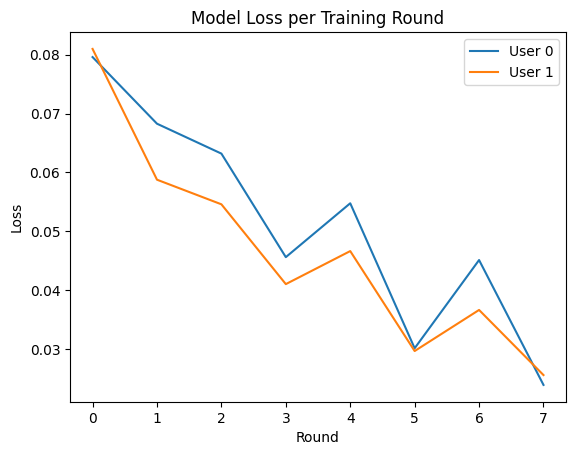

In [38]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL




def download_global_model_weights(user_cert, user_key, model_id):
    print("Downloading global model weights...")
    response = requests.get(
        url=f"{server}/app/global_model_weights?model_id={model_id}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    print("global model weights",response.text)

    if response.status_code == 200:
        model_weights_data = response.json().get("weights_json", {})
        model_weights_base64 = model_weights_data.get("model_weights_base64")

        if model_weights_base64:
            return json.loads(base64.b64decode(model_weights_base64).decode('utf-8'))
        else:
            print("Global model weights data not found in response.")
    else:
        print(f"Failed to download global model weights. Status code: {response.status_code}")

    return None

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, user_cert, user_key):
    print("Aggregating weights for model:", model_id)
  
    response = requests.get(
        url=f"{server}/app/aggregate_weights?model_id={model_id}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    print(response.text)
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')
    

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
      "global_model": {
        "model_name": "CNNModel",
        "model_data": model_base64
      }
    }
    response = requests.post(
        url=f"{server}/app/model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

# def serialize_weights(model):
#     """ Serialize only the weights of the model """
#     print("Serializing model weights...")
#     weights = model.get_weights()  # Get the model weights as a list of numpy arrays
#     weights_base64 = base64.b64encode(json.dumps([w.tolist() for w in weights]).encode()).decode()
#     return weights_base64
def serialize_weights(model):
    """ Serialize only the weights of the model """
    print("Serializing model weights...")
    weights = model.get_weights()  # Get the model weights as a list of numpy arrays
    return [w.tolist() for w in weights]


def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
  

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data
            
            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")
        
        time.sleep(2)  # Delay before retrying
        attempts += 1
    
    raise Exception("Failed to download model after maximum retries.")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

# Load and preprocess MNIST dataset
print("Loading and preprocessing MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

# Wait for some time after initial upload
time.sleep(1)  # Wait for 10 seconds

# Federated Learning Process
# Federated Learning Process
num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)

        # Serialize and upload the updated model weights for the current round
        model_weights_base64 = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty
        if model_weights_base64:
            upload_model_weights(model_weights_base64, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id
    )

    if global_model_weights:
        # Update local models with global weights
        local_model_user0.set_weights([np.array(w) for w in global_model_weights])
        local_model_user1.set_weights([np.array(w) for w in global_model_weights])
        print("Global model weights updated for both clients.")

print("Federated Learning Process Completed.")

# Plot loss graphs for each user
plot_loss(user_losses)
